# Basics

Before heading into linear regression and the generalized linear model, we introduce some basic notation.

## Data organization

*Structured* data is organized as one or multiple tables. Each row of a table represents an *observation*, each column $X$ a *variable* and each cell a *value*. A value in column $X$ can be viewed as a realization of the *random variable* $X$. 

Examples of *unstructured* data are images, text, audio or video data. We will deal with structured data only.

Throughout this lecture, we will consider the following two data sets:

- `diamonds`: Diamonds prices along with the four "C"-variables: Carat, Color, Cut, and Clarity. Each observation/row represents a diamond.

- `dataCar`: Insurance claim data on vehicle insurance policies from 2004-2005. Some variables like `gender` describe the policy holder, others like `veh_age` the vehicle and some variables carry information on eventual claims. Each row represents a policy.

### Example: diamonds

Let us have look at the first six observations of the diamonds data set.

In [70]:
from plotnine.data import diamonds
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Comment:** The data set is neatly structured. It seems to be sorted by price.

## Data types

We distinguish variables by their data type.

- **numerical:** The values of a numerical variable are numbers. Taking sums, means and differences makes sense. Examples: house prices, insurance claim frequencies, blood pressure.
- **categorical:** The values of a categorical variable are categories, e.g. house types, claim types or colors. Depending on whether categories follow a natural order, we talk of *ordered* or *unordered* categoricals. Categories can be encoded by numbers. That does not make the variable numeric though.
- **binary:** A binary variable just takes two values (male/female, yes/no, ...) that can be represented by 1/0. It counts as both numeric and categorical.

Data types are important in determining suitable analysis methods.

### Example: diamonds

In the `diamonds` data set, we will consider the numeric variables `price` and `carat` and the following *ordered* categoricals:

- `color` with ordered categories D < E < F < G < H < I < J,
- `cut` with ordered categories Fair < Good < Very Good < Premium < Ideal, and
- `clarity` with ordered categories I1 < SI2 < SI1 < VS2 < VS1 < VVS2 < VVS1 < IF.

There are no unordered categoricals or binary variables in this data set.

## Descriptive analysis

Statistical modeling always starts with a descriptive analysis of the data. This typically involves a numeric and/or graphical summary of each variable and the most relevant variable pairs, e.g. 

- for numeric variables: mean, standard deviation, quartiles, minimum and maximum; boxplots, mean plots,
- for categorical variables: absolute or relative counts; bar plots,
- for binary variables: like a categorical variable or simply the mean,
- for important pairs of numeric variables: correlations; scatter plots,
- the important pairs of categorical variables: frequency tables; mosaic plots,
- for important pairs of categorical *and* numerical variables: stratified means; mean plots, boxplots.

The more time we invest in the descriptive analysis, the more we learn about the data. Additionally, we might 

- identify data errors and problematic outliers (uncommonly small or large values), 
- find join keys to combine multiple data sources, 
- detect variables with high number of missing values,
- detect variables with no or almost no information (e.g. all values the same),
- **learn how the data is structured** (what *is* a row? do we deal with time series? are rows grouped to clusters etc.),
- ...

During or after the descriptive analysis, we usually do the *data preprocessing* for the modeling task.

### Example: diamonds

Let us summarize the diamonds data set.

#### Univariate description

,price,carat
count,53940.000000,53940.000000
mean,3932.799722,0.797940
std,3989.439738,0.474011
min,326.000000,0.200000
25%,950.000000,0.400000
50%,2401.000000,0.700000
75%,5324.250000,1.040000
max,18823.000000,5.010000


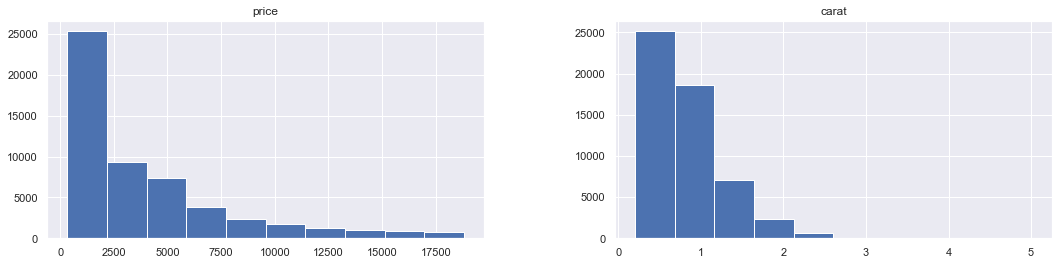

In [4]:
import seaborn as sns
sns.set_theme("notebook", style="darkgrid")
import matplotlib.pyplot as plt

diamonds[["price", "carat"]].hist(figsize=(18, 4))
diamonds[["price", "carat"]].describe()

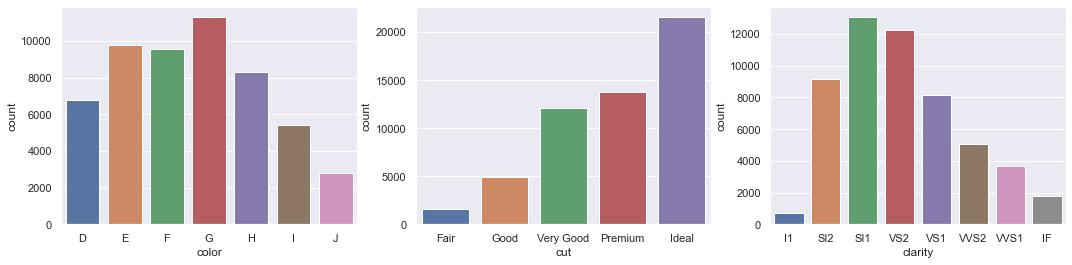

In [5]:
cat_vars = ["color", "cut", "clarity"]

fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for i, x in enumerate(cat_vars):
    sns.countplot(data=diamonds, x=x, ax=ax[i])

#### Associations with price

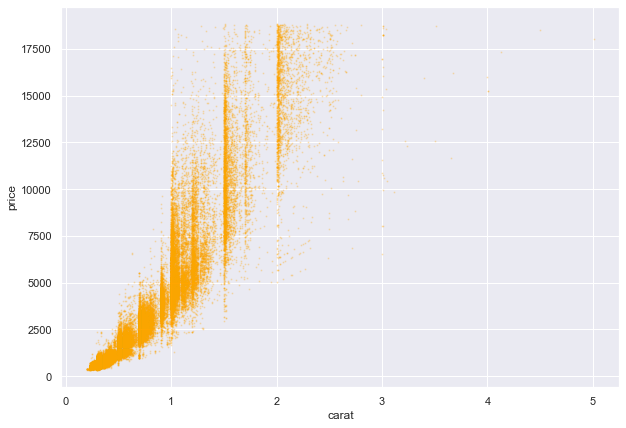

In [6]:
diamonds.plot.scatter(x="carat", y="price", alpha=0.2, 
                      color="orange", s=1, figsize=(10, 7));

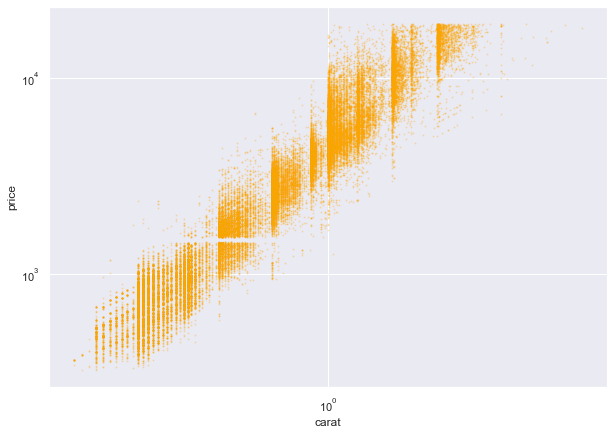

In [7]:
diamonds.plot.scatter(x="carat", y="price", alpha=0.2, color="orange",
                      s=1, loglog=True, figsize=(10, 7));

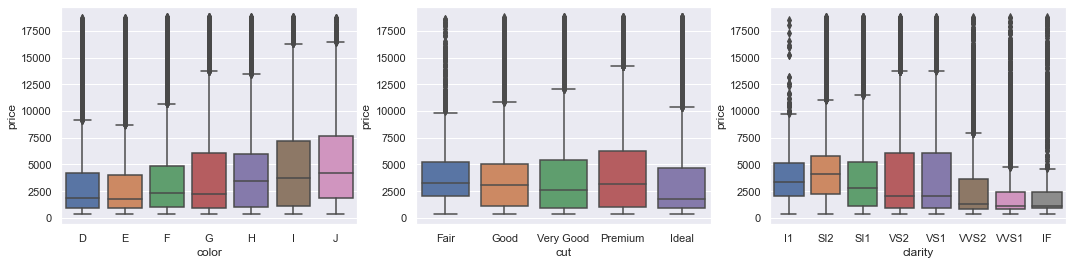

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))
for i, x in enumerate(cat_vars):
    sns.boxplot(data=diamonds, x=x, y="price", ax=ax[i])

**Comments**

- There are 53'940 observations in the diamonds data set.
- The average or mean diamond price is 3933 USD. About half of the diamonds cost less/more than the median of 2401 USD and about half of them cost between 950 USD (first quartile) and 5324 USD (third quartile). The lowest price is 326 USD, the highest price is 18'823 USD.
- Prices and carats show a *right-skewed* distribution with a few very large values.
- The relationship between price and carat seems quite strong and positive, which makes sense. On log-log scale, it looks linear.
- The worst categories of `color`, `cut`, and `clarity` are rare.
- Prices tend to be lower for nice colors, nice cuts as well as for nice clarities. This unintuitive behaviour will be entangled later by our regression models.

## Statistical models

The general modeling task is as follows: we want to approximate a *response variable* $Y$ by a function $f$ of $m$ *covariates* $X_1, \dots, X_m$, i.e.
$$
  Y \approx f(X_1, \dots, X_m).
$$
The function $f$ is unknown and we want to estimate it by $\hat f$ from observed data. 

Note: Think of the response $Y$ and the covariates $X_1, \dots, X_m$ as columns in a data set.

Normally, we are interested in modeling a specific property of $Y$, usually its expectation $E(Y)$ (= theoretic mean). In that case, we can make above approximate relationship more explicit by writing down the *model equation*
$$
  E(Y) = f(X_1, \dots, X_m).
$$

Once found, $\hat f$ serves as our prediction function that can be applied to fresh data. Furthermore, we can investigate the structure of $\hat f$ to gain insights about the relationship between response and covariates: what variables are especially important? how do they influence the response?

**Remark:** Other terms for "response variable" are "output", "target" or "dependent variable". Other terms for "covariate" are "input", "feature", "independent variable" or "predictor".

# Linear Regression

In order to get used to the terms mentioned above, we will look at the mother of all machine learning algorithms: (multiple) linear regression. It was first published by Adrien-Marie Legendre in 1805 [1] and is still very frequently used thanks to its simplicity, interpretability, and flexibility. It further serves as a simple benchmark for more complex algorithms and is the starting point for extensions like the generalized linear model.

## Model equation

The model equation of the linear regression is as follows:
$$
  E(Y) = f(X_1, \dots, X_m) = \beta_0 + \beta_1 X_1 + \cdots + \beta_m X_m.
$$
It relates the covariates $X_1, \dots, X_m$ to the expected response $E(Y)$ by a *linear* formula in the parameters $\beta_0, \dots, \beta_m$. The additive constant $\beta_0$ is called the *intercept*. The parameter $\beta_j$ tells us by how much $Y$ is expected to change when $X_j$ is increased by 1, **keeping all other covariates fixed** ("Ceteris Paribus"). Indeed:
$$
  E(Y \mid X_j = x + 1) - E(Y \mid X_j = x) = \beta_j (x + 1) - \beta_j x = \beta_j.
$$
The parameter $\beta_j$ is called *effect* of $X_j$ on the expected response $E(Y)$.

A linear regression with just one covariate is called a *simple* linear regression with equation 
$$
  E(Y) = \alpha + \beta X.
$$

## Least-squares

The optimal $\hat f$ to estimate $f$ is found by minimizing the sum of squared *prediction errors* resp. *residuals*
$$
  \sum_{i=1}^n e_i^2 = \sum_{i=1}^n (y_i - \hat y_i)^2.
$$
$y_i$ is the observed response of observation $i$ and $\hat y_i$ its prediction (or *fitted value*)
$$
  \hat y_i = \hat f(\text{Values of covariates of observation } i).
$$

Once the model is fitted, we can use the coefficients $\hat\beta_0, \dots, \hat\beta_m$ to make predictions and to study empirical effects of the covariates on the expected response.

### Example: simple linear regression

In order to discuss the typical output of a linear regression, we will now model diamond prices by their size. The model equation is
$$
  E(\text{price}) = \alpha + \beta \cdot \text{carat}.
$$


Fitted coefficients:
Intercept   -2256.360580
carat        7756.425618
dtype: float64

Predictions for diamonds with 1.3 carat?
 -Using 'predict': 7826.992723
 -By hand: 7826.992723


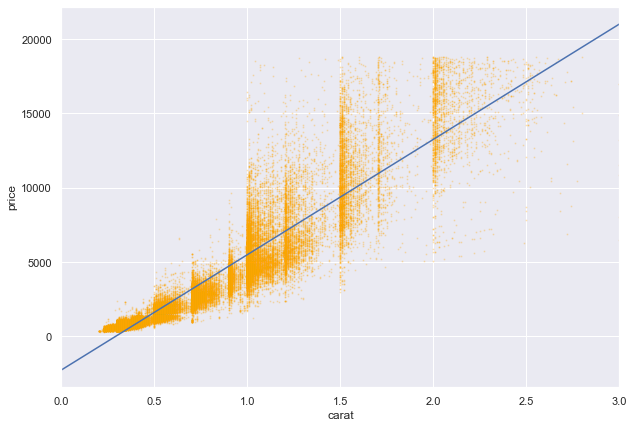

In [10]:
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from plotnine.data import diamonds

fit = smf.ols("price ~ carat", data=diamonds).fit()
print("Fitted coefficients:", fit.params, sep="\n")

# Scatter
diamonds.plot.scatter(x="carat", y="price", alpha=0.2, color="orange", 
                      s=1, figsize=(10, 7), xlim=(0, 3))

# Add regression line
x = np.linspace(0, 3, 100)
plt.plot(x, fit.params[0] + fit.params[1] * x);

print("\nPredictions for diamonds with 1.3 carat?")
print(f" -Using 'predict': {fit.predict({'carat': [1.3]})[0]:f}")

# By hand
print(f" -By hand: {fit.params[0] + fit.params[1] * 1.3:f}")


**Comments**

- **Regression coefficients:** The intercept $\alpha$ is estimated by $\hat \alpha = -2256$ and the effect of carat $\beta$ by $\hat \beta = 7756$ USD. This means that a 1 carat increase goes along with an average increase in price of 7756 USD. Similarly, we could say that a 0.1 increase in carat is associated with an increase in the price of 775.6 USD.
- **Regression line:** For a simple linear regression, the estimated regression coefficients $\hat \alpha$ and $\hat \beta$ can be visualized as a regression line. The latter represents the scatterplot as good as possible in the sense that the sum of squared vertical distances from the points to the line are minimal. The $y$-value at $x = 0$ equals $\hat \alpha = -2256$ and the slope of the line is $\hat \beta = 7756$.
- **Predictions:** Model predictions are made by using the fitted model equation $-2256 + 7756 \cdot \text{carat}$. For a diamond of size 1.3 carat, we get $-2256 + 1.3 \cdot 7756 \approx 7827$. These values correspond to the values on the regression line.

## Quality of the model

How good is a specific linear regression model? We may consider two aspects, namely 

- its predictive performance and 
- how well its assumptions are valid.

### Predictive performance

How precise are the model predictions? I.e., how well do predictions correspond with the observed response? In line with the least-squares approach, this is best quantified by the sum of squared prediction errors
$$
  \sum_{i = 1}^n (y_i - \hat y_i)^2
$$
or, equivalently, by the *mean-squared-error*
$$
  \text{MSE} = \frac{1}{n}\sum_{i = 1}^n (y_i - \hat y_i)^2.
$$
To quantify the size of the typical prediction error on the same scale as $Y$, we can take the square-root of the MSE and study the *root-mean-squared error* (RMSE). Minimizing MSE also minimizes RMSE.

Besides an *absolute* performance measure like the RMSE, we gain additional insights by studying a relative performance measure like the **R-squared**. It measures the relative decrease in MSE compared to the MSE of the "empty" or "null" model consisting only of an intercept. Put differently, the R-squared measures the proportion of variability of $Y$ explained by the covariates.

#### Example: simple linear regression (continued)

Let us calculate these performance measures for the simple linear regression above.


In [29]:
# Calculation by hand - later we will do them using scikit-learn
def mse(y, pred):
  return ((y - pred)**2).mean()

model_mse = mse(diamonds["price"], fit.predict(diamonds))
print(f"RMSE: {np.sqrt(model_mse):0.3f}")

empty_fit = smf.ols("price ~ 1", data=diamonds).fit()  # predictions equal diamonds$price.mean()
empty_mse = mse(diamonds["price"], empty_fit.predict(diamonds))

# R-squared
r_squared = (empty_mse - model_mse) / empty_mse
print(f"R-squared: {r_squared:.2%}")

RMSE: 1548.533
R-squared: 84.93%


**Comments**

- **RMSE:** The RMSE is 1549 USD. This means that residuals (= prediction errors) are typically around 1549 USD.
- **R-squared:** The R-squared shows that about 85% of the price variability can be explained by variability in carat.

### Model assumptions

The main assumption of linear regression is a **correctly specified model equation** in the sense that predictions are not systematically too high or too small for certain values of the covariates. In a simple regression setting, this means that the points in the scatterplot are located *around* the regression line for all covariate values. For a multiple linear regression, this translates to the empirical condition that residuals (differences between observed and fitted response) do not show bias if plotted against covariate values.

Additional assumptions like independence of rows, constant variance of the error term $\varepsilon$ in the equation
$$
  Y = f(X_1, \dots, X_m) + \varepsilon
$$
and normal distribution of $\varepsilon$ guarantee optimality of the least-squares estimator $\hat \beta_0, \dots, \hat\beta_m$ and the correctness of inferential statistics (standard errors, p values, confidence intervals). In that case, we talk of the *normal linear model*. Its conditions are checked by studying *diagnostic plots*. We skip this part for brevity and since we are not digging into inferential statistics.

#### Example: simple linear regression (continued)

When looking at the scatter plot enhanced with the regression line from above, we can spot systematically too low (even negative!) predictions for very small diamonds. This indicates a wrongly specified model. Later, we will see ways to fix this.

## Typical problems

Here, we list some problems that frequently occurs with linear regression. We will only mention them without going into details.

### Missing values

Like many other ML algorithms, linear regression cannot deal with missing values. Rows with missing response can be safely dropped, while missing values in covariates should usually be dealt with. The simplest (often too naive) approach is to fill missing values with a typical value such as the mean or the most frequent value.

### Outliers

Gross outliers in covariates can distort the result of the linear regression. Do not delete them, but try to reduce their effect by taking logarithms or by using more robust regression techniques. Outliers in the response can be problematic as well, especially for inferential statistics.

### Overfitting

If too many parameters are used in relation to the number of observations, the resulting model might look good but would not generalize well to new data. This is called overfitting. A small amount of overfitting is unproblematic. Do not fit a model with $m=100$ parameters on a data set with just $n=200$ rows. The resulting model would be garbage. A $n/m$ ratio of 50-100 is usually safe for stable estimation of parameters.

### Collinearity

If the association between two or more covariates is strong, their coefficients are difficult to interpret because the Ceteris Paribus clause is usually unnatural in such situations. In a house price model, for instance, it is unnatural to study the effect of an additional room, keeping living area fixed. This is even more problematic for causally dependent covariates: imagine a model with $x$ and $x^2$ as covariates. It would certainly not make sense to study the effect of $x$ while keeping $x^2$ fixed. 

Strong collinearity can be detected by looking at correlations across (numeric) covariates. It is mainly a problem when interpreting effects or for statistical inference of effects. Predictions or other "global" model characteristics like the R-squared are not affected.

Often, collinearity can be reduced by transforming the covariates in a way that makes the Ceteris Paribus clause natural. Instead of, e.g., using number of rooms and living area in a house price model, it might help to represent living area by the derived variable "living area per room".

Note: Perfectly collinear covariates (for example $X$ and $2X$) cannot be used for algorithmic reasons.

## Categorical covariates

Since algorithms usually only understand numbers, categorical variables have to be encoded by numbers. The standard approach is called **one-hot-encoding** (OHE) and works as follows: Each level $x_k$ of the categorical variable $X$ gets its own binary **dummy** variable $D_k = 1(X = x_k)$, indicating if $X$ has this particular value or not. In linear models, one of the dummy variables ($D_1$, say) needs to be dropped due to perfect collinearity (for each row, the sum of OHE variables is always 1). Its level is automatically being represented by the intercept. This variant of OHE is called **dummy coding**.

For our diamonds data set, OHE for the variable `color` looks as follows (the first column is the original categorical variable, the other columns are the dummy variables):

![](../figs/ohe.PNG)

**Comments on categorical covariates**

- **Interpretation:** Interpreting the regression coefficient $\beta_k$ of the dummy variable $D_k$ is nothing special: It tells us how much $E(Y)$ changes when the dummy variable switches from 0 to 1. This amounts to switching from the reference category (the one without dummy) to category $k$.
- **Integer encoding:** Ordinal categorical covariates are sometimes integer encoded for simplicity, i.e., each category is represented by an integer number. 
- **Small categories:** In order to reduce overfitting, small categories are sometimes combined to a level "Other" or are added to the largest category.

### Example: dummy coding

Let us now extend the simple linear regression for diamond prices by adding dummy variables for the categorical covariate `color`.

In [17]:
(diamonds["price"]-fit.predict(diamonds))^2

TypeError: Cannot perform 'xor' with a dtyped [float64] array and scalar of type [bool]

In [9]:
x_ord = ["cut", "color", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in x_ord]
ord_levels

preprocessor = ColumnTransformer(
    transformers=[
        ("log", FunctionTransformer(np.log), ["carat"]),
        ("encoder", OrdinalEncoder(categories=ord_levels), x_ord)
    ],
    remainder="drop"
)

X = preprocessor.fit_transform(diamonds)
X